In [16]:
# Basics
import os
import pandas as pd
import numpy as np

# NLP
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import WhitespaceTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
import gensim
from joblib import dump

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

In [3]:
# Class definition
class TopicModellingSklearn:
    def __init__(self,text,text_proc_check,min_df,max_df,n_components,random_state):
        """ 
        Initialize class. 
        
        Arguments:
            text - DF column containing text block
            text_proc_check = Boolean controlling whether text is preprocessed
            min_df = Minimum number of articles the word must appear in for the
                word to be considered.
            max_df = Threshold for unique words to considered (drop words 
               appearing too frequently, as in stopwords)
            n_topics = Number of topics to consider
            random_seed = Random seed to use for the modelling
        """
        # Set up internal class variables
        self.text = text
        self.text_proc_check = text_proc_check
        self.min_df = min_df
        self.max_df = max_df
        self.n_components = n_components
        self.random_state = random_state
        
        # Pre-process text if requested
        if self.text_proc_check == True:
            self.text_preprocess()
            
            
        # Fit an LDA model
        self.LDA_model, self.word_frequency, self.vocabulary = self.LDA_model()
    
    def text_preprocess(self):
        """ 
        Arguments:
            text - pandas series where each entry is the unprocessed text of
                a given article.
            
        Outputs:
            text_proc - pandas series where the article text has been processed
                based on the following workflow:
                    (1) Case consistency (all lowercase)
                    (2) Lemmatizing
        """   
        lemmatizer = WordNetLemmatizer()
        
        for article in range(0,len(self.text)):
            # Print a status update
            if np.remainder(article,100) == 0:
                print("Pre-processing requested. Lemmatizing checkpoint {}.".format(article))
#                print("Original article: {}".format(self.text[article][0:500]))
            
            # Process article text, overwrite original text
            article_text_proc = []
            article_text = self.text[article].split(" ")
            for word in article_text:
                word = word.lower()
                article_text_proc.append(lemmatizer.lemmatize(word))
            self.text[article] = " ".join(article_text_proc)
            
#            if np.remainder(article,100) == 0:
#                print("Lemmatized article: {}".format(self.text[article][0:500]))
            
    def LDA_model(self):
        """ Fit text to an LDA model """
        word_frequency = CountVectorizer(min_df = self.min_df,
                                         stop_words = 'english')
        vocabulary = word_frequency.fit_transform(
                self.text.values.astype('U'))
        
        LDA = LatentDirichletAllocation(n_components = self.n_components,
                                        random_state = self.random_state)
        LDA_model = LDA.fit(vocabulary)
        
        return LDA_model, word_frequency, vocabulary


In [4]:
# Import data
filedir = os.path.dirname(os.path.realpath('__file__'))
filename = os.path.join('../data/processed/articles_python.csv')
filename = os.path.abspath(os.path.realpath(filename))
articles_python = pd.read_csv(filename,index_col = "postId")

In [5]:
# Model Alpha: sklearn/LDA (unsupervised); No pre-processing of text
model_alpha = TopicModellingSklearn(text=articles_python["text"],
                                       text_proc_check=False,
                                       min_df = 3,
                                       max_df = [],
                                       n_components = 10,
                                       random_state = 8)
print('Model alpha:')
for i, topic in enumerate(model_alpha.LDA_model.components_):
    print('Top words for topic {}:'.format(i))
    print([model_alpha.word_frequency.get_feature_names()[i] for i in topic.argsort()[-20:]])
    print('\n')

Model alpha:
Top words for topic 0:
['negative', 'context', 'positive', 'reviews', 'sentiment', 'using', 'accuracy', 'word2vec', 'set', 'use', 'training', 'embeddings', 'embedding', 'text', 'vector', 'data', 'vectors', 'model', 'words', 'word']


Top words for topic 1:
['example', 'variables', 'mean', 'variable', 'number', 'columns', 'distribution', 'dataframe', 'like', 'column', 'function', 'using', 'python', 'pandas', 'value', 'plot', 'let', 'use', 'values', 'data']


Top words for topic 2:
['layers', 'models', 'example', 'deep', 'need', 'output', 'code', 'learning', 'neural', 'function', 'input', 'network', 'keras', 'using', 'layer', 'data', 'training', 'use', 'tensorflow', 'model']


Top words for topic 3:
['make', 'google', 'want', 'app', 'machine', 'notebook', 'new', 'run', 'll', 'api', 'create', 'time', 'need', 'like', 'python', 'file', 'using', 'use', 'code', 'data']


Top words for topic 4:
['network', 'test', 'like', 'let', 'arima', 'trend', 'average', 'image', 'learning', 't

In [6]:
model_alpha_dict = {0 : 'natural language processing',
                    1 : 'general data science',
                    2 : 'neural networks',
                    3 : 'machine learning',
                    4 : 'time series modelling',
                    5 : 'natural language processing',
                    6 : 'supervised learning',
                    7 : 'supervised learning',
                    8 : 'neural networks',
                    9 : 'machine learning',
                    10 : 'unassigned'}

In [7]:
topic_prob_alpha = model_alpha.LDA_model.transform(model_alpha.vocabulary)
articles_python = articles_python.assign(topic_label_alpha = np.zeros(len(articles_python)))
articles_python['topic_label_alpha'] = topic_prob_alpha.argmax(axis = 1)
articles_python['topic_label_alpha'] = articles_python['topic_label_alpha'].map(model_alpha_dict)


In [8]:
for i in range(0,50):
    print("Article #{}".format(i))
    print("Title:{}".format(articles_python["title"].iloc[i]))
    print("Label: {}".format(articles_python["topic_label_alpha"].iloc[i]))
    print('\n')

Article #0
Title:How to build your own AlphaZero AI using Python and Keras
Label: neural networks


Article #1
Title:Python is the Perfect Tool for any Problem
Label: machine learning


Article #2
Title:A Complete Machine Learning Walk-Through in Python: Part One
Label: supervised learning


Article #3
Title:Train Your Machine Learning Models on Google’s GPUs for Free — Forever
Label: machine learning


Article #4
Title:How you can train an AI to convert your design mockups into HTML and CSS
Label: supervised learning


Article #5
Title:Python for Data Science: 8 Concepts You May Have Forgotten
Label: general data science


Article #6
Title:Web Scraping, Regular Expressions, and Data Visualization: Doing it all in Python
Label: machine learning


Article #7
Title:Automated Feature Engineering in Python
Label: supervised learning


Article #8
Title:How to colorize black & white photos with just 100 lines of neural network code
Label: supervised learning


Article #9
Title:A simple deep 

In [9]:
model_alpha_count = articles_python.groupby(["topic_label_alpha"]).size().reset_index(
        name="counts")
model_alpha_count = model_alpha_count.sort_values(["counts"],ascending=False)
print(model_alpha_count.head())

             topic_label_alpha  counts
4          supervised learning     388
1             machine learning     327
3              neural networks     278
0         general data science     224
2  natural language processing     164


In [18]:
pyLDAvis.sklearn.prepare(model_alpha.LDA_model, model_alpha.vocabulary, model_alpha.word_frequency)

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.028859  0.051907       1        1  17.018386
3      0.140581 -0.100736       2        1  15.727132
1      0.076147 -0.008803       3        1  14.746078
8     -0.070968 -0.036211       4        1  11.726225
6     -0.080921 -0.061670       5        1   9.783727
2     -0.069509 -0.092160       6        1   8.673779
5      0.107141  0.074134       7        1   7.023108
9      0.088621  0.070766       8        1   6.838782
4     -0.064830 -0.056488       9        1   4.234527
0     -0.097403  0.159261      10        1   4.228256, topic_info=      Category          Freq            Term         Total  loglift  logprob
6836   Default  10072.000000           model  10072.000000  30.0000  30.0000
5325   Default   3326.000000           image   3326.000000  29.0000  29.0000
11643  Default   1713.000000            word   1713.000000  28.0000  28.0000
11651  Default   2071.000000           words   2071.000000  27.0000  27.0000
5331   Default   2158.000000          images   2158.000000  26.0000  26.0000
10556  Default   1691.000000      tensorflow   1691.000000  25.0000  25.0000
10584  Default   1706.000000            text   1706.000000  24.0000  24.0000
2884   Default  18151.000000            data  18151.000000  23.0000  23.0000
10695  Default   3989.000000            time   3989.000000  22.0000  22.0000
10836  Default   4302.000000        training   4302.000000  21.0000  21.0000
7091   Default   2670.000000         network   2670.000000  20.0000  20.0000
9493   Default   1572.000000          series   1572.000000  19.0000  19.0000
7095   Default   2334.000000          neural   2334.000000  18.0000  18.0000
6112   Default   1948.000000           layer   1948.000000  17.0000  17.0000
4243   Default   3305.000000        features   3305.000000  16.0000  16.0000
11323  Default    732.000000         vectors    732.000000  15.0000  15.0000
11315  Default   1113.000000          vector   1113.000000  14.0000  14.0000
5971   Default   1057.000000           keras   1057.000000  13.0000  13.0000
6152   Default   5886.000000        learning   5886.000000  12.0000  12.0000
11229  Default   1150.000000            user   1150.000000  11.0000  11.0000
4237   Default   2400.000000         feature   2400.000000  10.0000  10.0000
9875   Default    629.000000           spark    629.000000   9.0000   9.0000
527    Default   1625.000000        accuracy   1625.000000   8.0000   8.0000
5587   Default   2070.000000           input   2070.000000   7.0000   7.0000
6844   Default   2355.000000          models   2355.000000   6.0000   6.0000
4590   Default   4455.000000        function   4455.000000   5.0000   5.0000
2991   Default   1662.000000            deep   1662.000000   4.0000   4.0000
7581   Default   1349.000000          pandas   1349.000000   3.0000   3.0000
8741   Default   1561.000000      regression   1561.000000   2.0000   2.0000
763    Default   1796.000000       algorithm   1796.000000   1.0000   1.0000
...        ...           ...             ...           ...      ...      ...
6416   Topic10    133.613726            lstm    247.206957   2.5481  -5.7117
9464   Topic10    208.534462       sentiment    468.999220   2.3529  -5.2665
2531   Topic10    194.156893         context    435.741843   2.3550  -5.3380
9462   Topic10    176.163917        sentence    384.128992   2.3838  -5.4352
1937   Topic10    115.752651       character    223.345647   2.5061  -5.8552
9463   Topic10    105.171562       sentences    216.244365   2.4426  -5.9510
2644   Topic10    140.163779          corpus    329.072077   2.3099  -5.6638
9484   Topic10     71.953033       sequences    134.017185   2.5414  -6.3306
9740   Topic10     83.315704            skip    171.098489   2.4438  -6.1840
1263   Topic10     85.044409             bag    179.655324   2.4155  -6.1634
10584  Topic10    368.711776            text   1706.892668   1.6310  -4.696

In [10]:
# Model Beta: sklearn/LDA (unsupervised); text case consistency + lemmatization
model_beta = TopicModellingSklearn(text=articles_python["text"],
                                       text_proc_check=True,
                                       min_df = 3,
                                       max_df = 0.5,
                                       n_components = 10,
                                       random_state = 8)

print('Model beta:')
for i, topic in enumerate(model_beta.LDA_model.components_):
    print('Top words for topic {}:'.format(i))
    print([model_beta.word_frequency.get_feature_names()[i] for i in topic.argsort()[-20:]])
    print('\n')

Pre-processing requested. Lemmatizing checkpoint 0.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Pre-processing requested. Lemmatizing checkpoint 100.
Pre-processing requested. Lemmatizing checkpoint 200.
Pre-processing requested. Lemmatizing checkpoint 300.
Pre-processing requested. Lemmatizing checkpoint 400.
Pre-processing requested. Lemmatizing checkpoint 500.
Pre-processing requested. Lemmatizing checkpoint 600.
Pre-processing requested. Lemmatizing checkpoint 700.
Pre-processing requested. Lemmatizing checkpoint 800.
Pre-processing requested. Lemmatizing checkpoint 900.
Pre-processing requested. Lemmatizing checkpoint 1000.
Pre-processing requested. Lemmatizing checkpoint 1100.
Pre-processing requested. Lemmatizing checkpoint 1200.
Pre-processing requested. Lemmatizing checkpoint 1300.
Pre-processing requested. Lemmatizing checkpoint 1400.
Model beta:
Top words for topic 0:
['sentence', 'processing', 'entity', 'example', 'python', 'file', 'language', 'used', 'analysis', 'review', 'let', 'code', 'like', 'sentiment', 'spark', 'using', 'use', 'word', 'text', 'data']


Top words

In [11]:
model_beta_dict = {0 : 'natural language processing',
                    1 : 'machine learning',
                    2 : 'supervised learning',
                    3 : 'natural language processing',
                    4 : 'machine learning',
                    5 : 'supervised learning',
                    6 : 'neural networks',
                    7 : 'general data science',
                    8 : 'neural networks',
                    9 : 'general data science',
                    10 : 'unassigned'}

In [12]:
topic_prob_beta = model_beta.LDA_model.transform(model_beta.vocabulary)
articles_python = articles_python.assign(topic_label_beta = np.zeros(len(articles_python)))
articles_python['topic_label_beta'] = topic_prob_beta.argmax(axis = 1)
articles_python['topic_label_beta'] = articles_python['topic_label_beta'].map(model_beta_dict)

In [13]:
for i in range(0,50):
    print("Article #{}".format(i))
    print("Title:{}".format(articles_python["title"].iloc[i]))
    print("Label: {}".format(articles_python["topic_label_beta"].iloc[i]))
    print('\n')

Article #0
Title:How to build your own AlphaZero AI using Python and Keras
Label: neural networks


Article #1
Title:Python is the Perfect Tool for any Problem
Label: machine learning


Article #2
Title:A Complete Machine Learning Walk-Through in Python: Part One
Label: machine learning


Article #3
Title:Train Your Machine Learning Models on Google’s GPUs for Free — Forever
Label: machine learning


Article #4
Title:How you can train an AI to convert your design mockups into HTML and CSS
Label: natural language processing


Article #5
Title:Python for Data Science: 8 Concepts You May Have Forgotten
Label: general data science


Article #6
Title:Web Scraping, Regular Expressions, and Data Visualization: Doing it all in Python
Label: general data science


Article #7
Title:Automated Feature Engineering in Python
Label: general data science


Article #8
Title:How to colorize black & white photos with just 100 lines of neural network code
Label: neural networks


Article #9
Title:A simple

In [14]:
model_beta_count = articles_python.groupby(["topic_label_beta"]).size().reset_index(
        name="counts")
model_beta_count = model_beta_count.sort_values(["counts"],ascending=False)
print(model_beta_count.head())

              topic_label_beta  counts
3              neural networks     395
1             machine learning     307
0         general data science     294
4          supervised learning     235
2  natural language processing     198


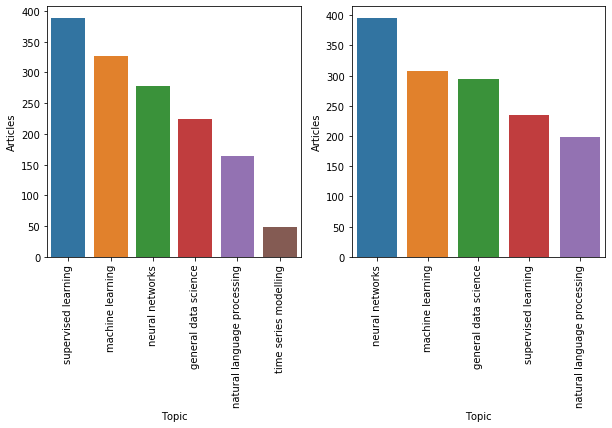

In [15]:
# Plot distributions of the topic categorizations for each model
fig = plt.figure(figsize=(10,6))

ax1 = fig.add_subplot(1,2,1)
sns.barplot(x = model_alpha_count["topic_label_alpha"],
            y = model_alpha_count["counts"])
plt.xticks(rotation=90)
ax1.set_xlabel("Topic")
ax1.set_ylabel("Articles")
        
ax2 = fig.add_subplot(1,2,2)
sns.barplot(x = model_beta_count["topic_label_beta"],
            y = model_beta_count["counts"])
plt.xticks(rotation=90)
ax2.set_xlabel("Topic")
ax2.set_ylabel("Articles")
    
fig.subplots_adjust(bottom=0.3)